This is a write-up that works out some numbers for the wavelength accuracy discussion and is aimed at clarifying how we determine our CBE.

The question is:
- How accurately can we know the wavelength of an extracted microspectrum?

Our approach is to simulate a monochromatic flatfield of psflets on the detector, proceed to our current "wavelength update" algorithm, and repeat for a large amount of times. The mean and standard deviation of the errors between known and measured are our CBE.

The method used to describe the psflet grid is an interpolation and optimization method pioneered for the CHARIS data reduction pipeline by Tim Brandt. It describes the grid of x, y pixel positions as a low-order polynomial of i and j lenslet integer position in the lenslet array.

We have not yet determined whether the fitting function that we use is usable on-orbit, so its performance might not be representative of the routine that will eventually be implemented on the flight software.

### Initialize Python

In [1]:
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.

Populating the interactive namespace from numpy and matplotlib


# Wavelength update

## Create polynomial coefficients for psflet coordinate grid

The order with which the polynomial coefficients are to be input is shown below.

In [2]:
from crispy.tools.locate_psflets import revealCoefs
newcoefs = [512.3, 12., 0.0, 0.0, -6.0, 0.0, 0.0, 0.0, 0.0, 0.0,
            511.8, 6., 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0]
print revealCoefs(newcoefs,order=3)

i and j are the integer coordinates of the lenslets in the array
X coordinates:
512.3 * i^0 j^0 + 
12.0 * i^0 j^1 + 
0.0 * i^0 j^2 + 
0.0 * i^0 j^3 + 
-6.0 * i^1 j^0 + 
0.0 * i^1 j^1 + 
0.0 * i^1 j^2 + 
0.0 * i^2 j^0 + 
0.0 * i^2 j^1 + 
0.0 * i^3 j^0 + 
Y coordinates:
511.8 * i^0 j^0 + 
6.0 * i^0 j^1 + 
0.0 * i^0 j^2 + 
0.0 * i^0 j^3 + 
12.0 * i^1 j^0 + 
0.0 * i^1 j^1 + 
0.0 * i^1 j^2 + 
0.0 * i^2 j^0 + 
0.0 * i^2 j^1 + 
0.0 * i^3 j^0 + 



## Create monochromatic map

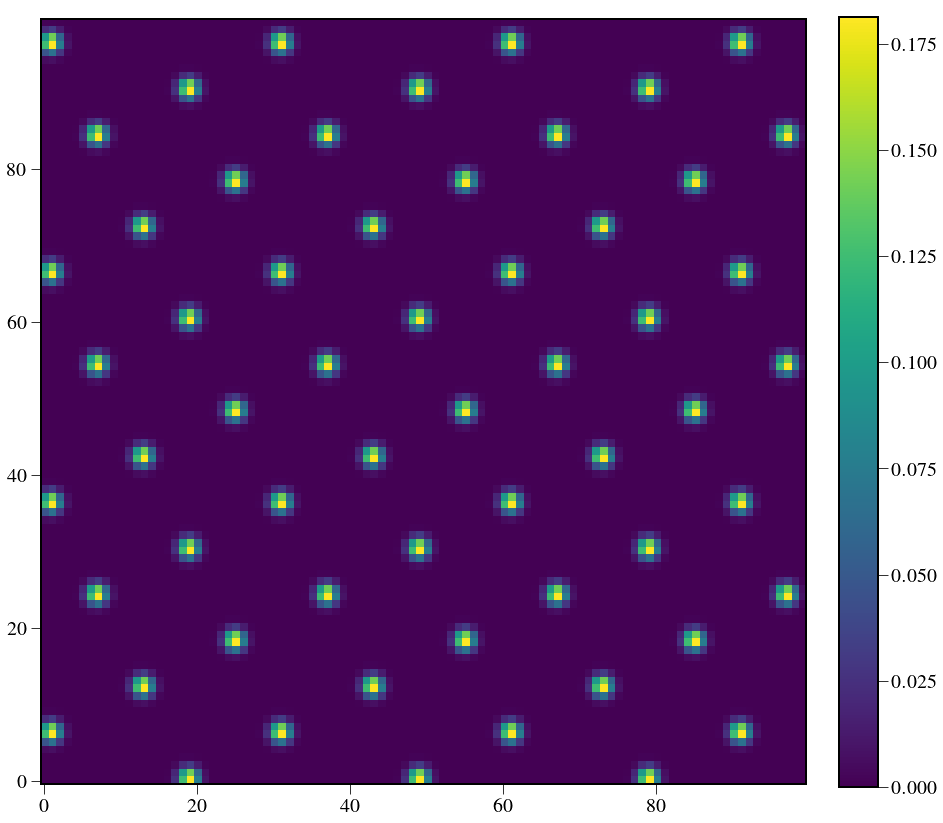

In [3]:
from crispy.IFS import quickMonochromatic
from crispy.tools.locate_psflets import transform
det,coords = quickMonochromatic(coefs=newcoefs,returnCoords=True)
plt.figure(figsize=(15,15))
plt.imshow(det[500:600,500:600])
plt.colorbar(fraction=0.046, pad=0.04)

## Example of a noisy map

We are considering a Poisson-noise only situation with no background noise, but the situation is very flexible and we could add a background if desired.

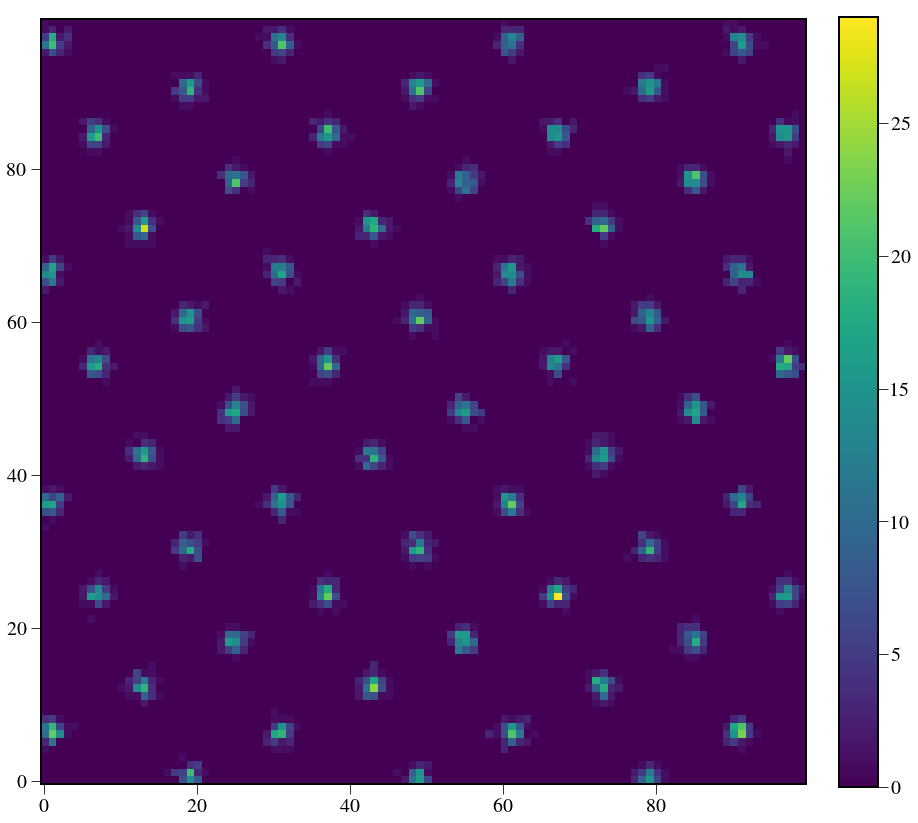

In [4]:
SNR=10
noisy = np.random.poisson(SNR**2*det)
plt.figure(figsize=(15,15))
plt.imshow(noisy[500:600,500:600])
plt.colorbar(fraction=0.046, pad=0.04)

## Run a wavelength calibration for N trials

In [5]:
from crispy.tools.image import Image
from crispy.tools.locate_psflets import locatePSFlets
from IPython.display import clear_output
ntrials = 50
SNR = 10
xlist = []
ylist = []
snrlist = []

# we assume that we already have a good knowledge of the psflet map
# note that the first coef is different (512, 512) instead of (512.3, 519.8)
coef = [512.0, 12., 0.0, 0.0, -6.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        512.0, 6., 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0]

for i in range(ntrials):
    # Clear output
    clear_output()
    
    # iteration of noise
    noisy = np.random.poisson(SNR**2*det)
    ysize, xsize = noisy.shape
    
    # load image with correct crispy function
    im = Image(data=noisy)

    # run wavelength calibration step
    x, y, good, newcoef = locatePSFlets(im, 
                                    polyorder=3, # polynomial is order 3
                                    mask=np.ones((ysize, xsize)), # all pixels are valid
                                    sig=2., # psflets are about 2 pixels fwhm
                                    coef=coef, # guess coefs
                                    trimfrac=0.0) # use all the lenslets

    # 0.5 pixel offset is systematic, so take it out here (this has no impact later)
    xlist.append(coords[0]-x+0.5)
    ylist.append(coords[1]-y+0.5)


crispy - INFO - Initializing transformation coefficients with previous values
crispy - INFO - Performing final optimization of PSFlet location transformation coefficients for frame 
crispy - INFO - Array origin: (512.80576234279363, 512.29503951908634)


## Save files to fits

In [6]:
from astropy.io import fits
xlistarr = np.array(xlist)
ylistarr = np.array(ylist)
out = fits.HDUList(fits.PrimaryHDU(xlistarr.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/xlistarr%d.fits' % (ntrials),overwrite=True)
out = fits.HDUList(fits.PrimaryHDU(ylistarr.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/ylistarr%d.fits' % (ntrials),overwrite=True)


## Display mean and std of error across multiple trials

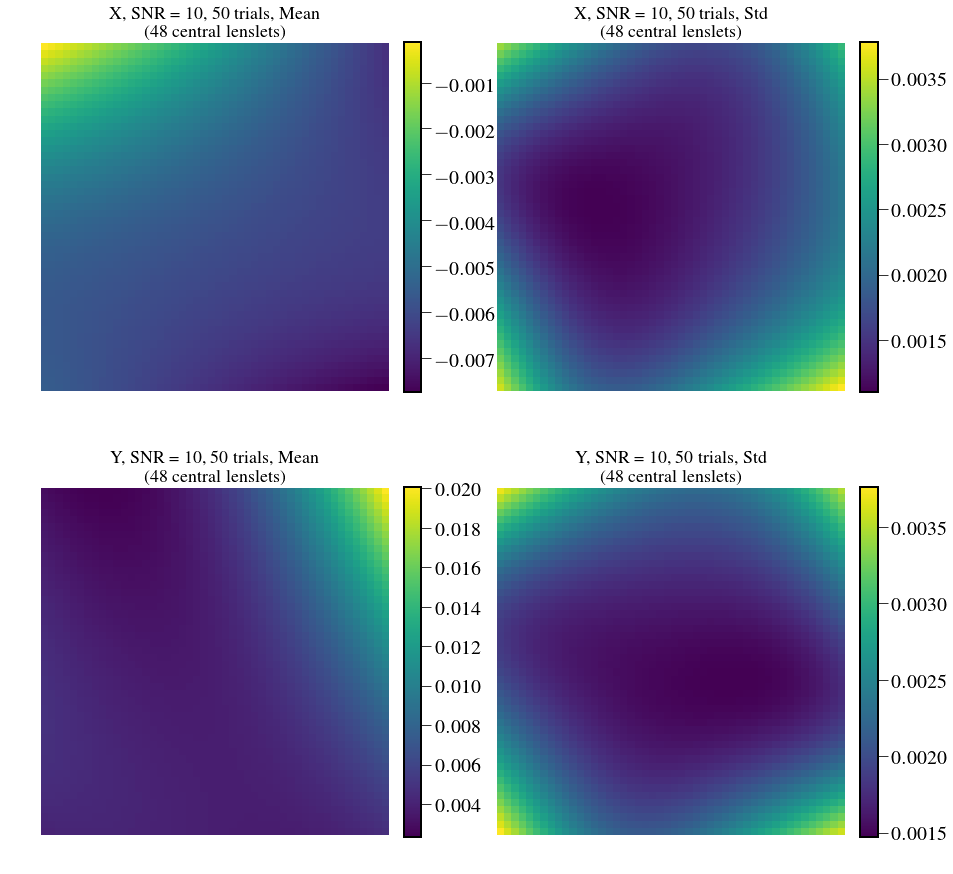

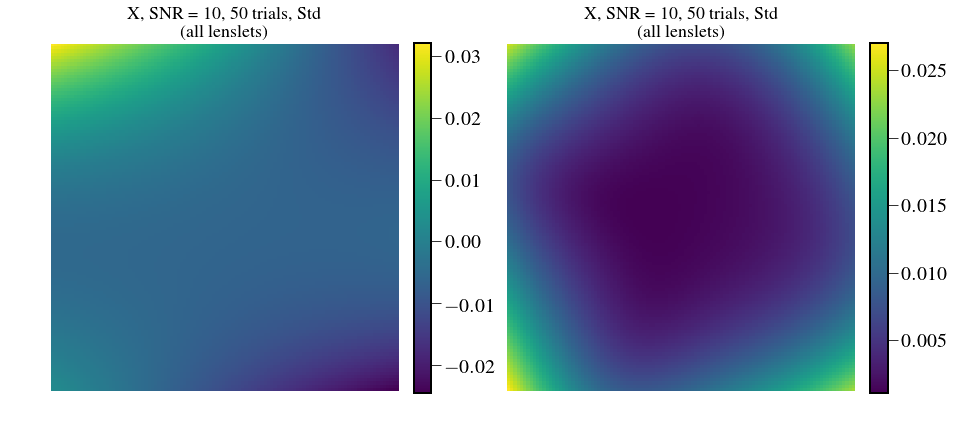

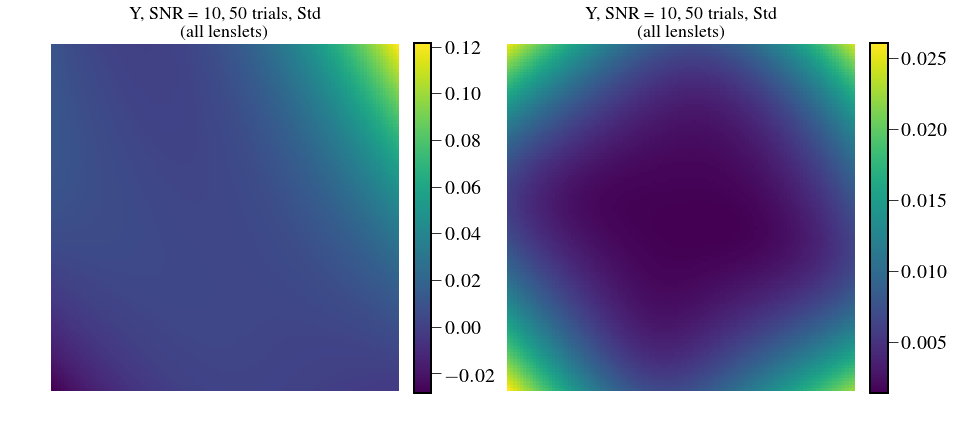

In [7]:

crop=30
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(np.mean(xlistarr,axis=0)[crop:-crop,crop:-crop])
plt.title('X, SNR = %d, %d trials, Mean \n (%d central lenslets)'%(SNR,ntrials,108-2*crop))
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(222)
plt.imshow(np.std(xlistarr,axis=0)[crop:-crop,crop:-crop])
plt.title('X, SNR = %d, %d trials, Std \n (%d central lenslets)'%(SNR,ntrials,108-2*crop))
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(223)
plt.imshow(np.mean(ylistarr,axis=0)[crop:-crop,crop:-crop])
plt.title('Y, SNR = %d, %d trials, Mean \n (%d central lenslets)'%(SNR,ntrials,108-2*crop))
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(224)
plt.imshow(np.std(ylistarr,axis=0)[crop:-crop,crop:-crop])
plt.title('Y, SNR = %d, %d trials, Std \n (%d central lenslets)'%(SNR,ntrials,108-2*crop))
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(np.mean(xlistarr,axis=0))
plt.title('X, SNR = %d, %d trials, Std \n (all lenslets)'%(SNR,ntrials))
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(np.std(xlistarr,axis=0))
plt.title('X, SNR = %d, %d trials, Std \n (all lenslets)'%(SNR,ntrials))
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(np.mean(ylistarr,axis=0))
plt.title('Y, SNR = %d, %d trials, Std \n (all lenslets)'%(SNR,ntrials))
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(np.std(ylistarr,axis=0))
plt.title('Y, SNR = %d, %d trials, Std \n (all lenslets)'%(SNR,ntrials))
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)


# Fine wavelength calibration

The wavelength update accuracy cannot do better than the original knowledge of the centroids in the grid, which will be determined in the lab by cycling through several monochromatic flatfields. The question then becomes, how accurate can we determine the centroids of each and every lenslet in the lab? For this, it is not reasonable to make the assumption that the grid is perfect to begin with (we do not impose a strict requirement on the vendor). Thus, without this assumption of grid smoothness, the centroid of every individual psflet has to be measured. In practice, we do observe small deviations that are at higher spatial frequency than what the polynomial fit can capture.

The calibration is run in the PISCES notebook which uses lab data obtained at HCIT. A broadband flatfield is formed as a sum of the monochromatic flatfields used for wavelength calibration, and extracted. Below we show the difference between using the fine wavelength calibration method (individual centroids) and not using it on a particular region of the image.

## Comparison with/without fine calibration step

(-0.5, 199.5, -0.5, 199.5)

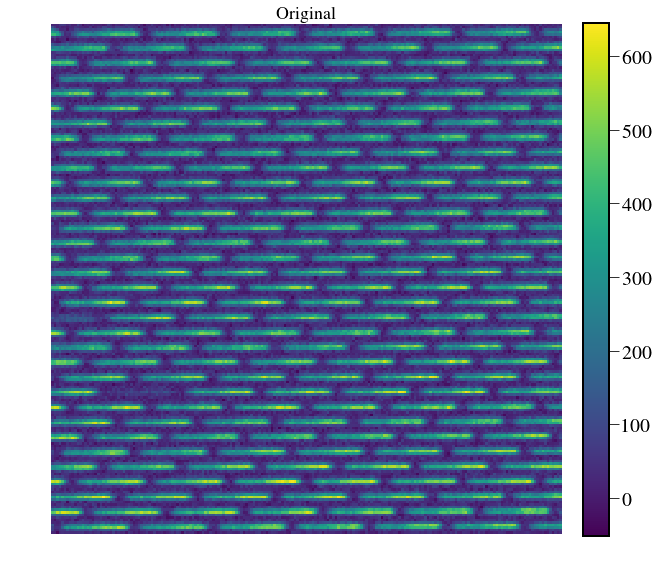

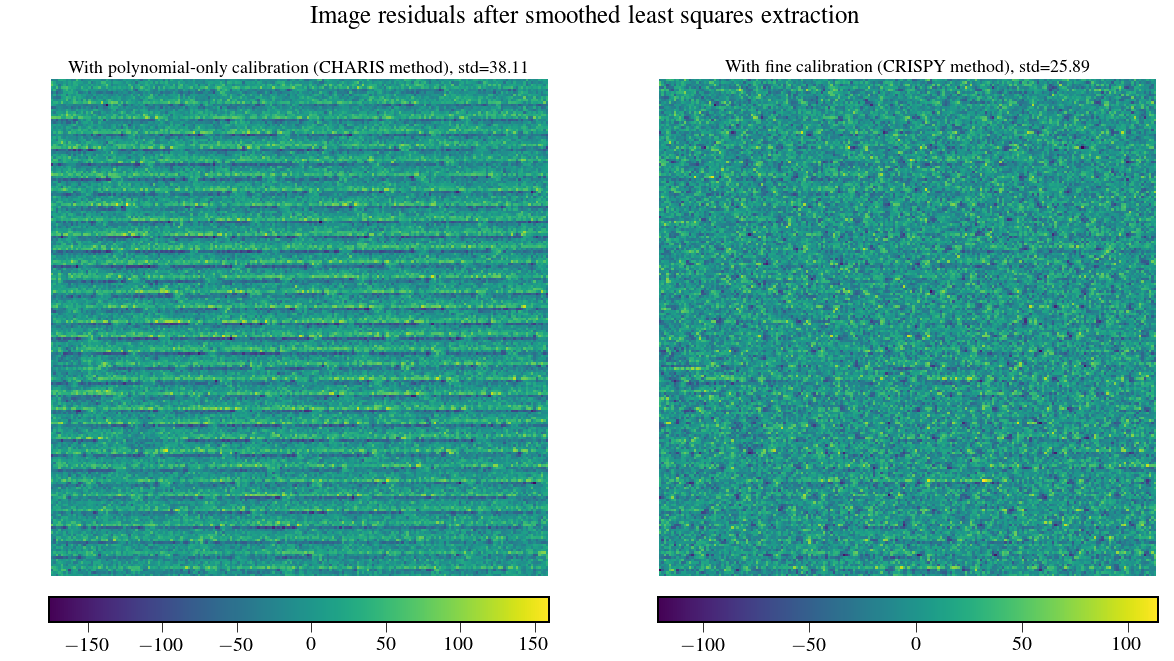

In [8]:
original = fits.getdata('/Users/mrizzo/Downloads/newflat.fits')
nofine = fits.getdata('/Users/mrizzo/IFS/crispy/crispy/SimResults/newflat_red_lstsq_resid_nofine.fits')
fine = fits.getdata('/Users/mrizzo/IFS/crispy/crispy/SimResults/newflat_red_lstsq_resid.fits')
plt.figure(figsize=(10,10))
plt.imshow(original[600:800,400:600])
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('Original')
plt.figure(figsize=(20,10))
plt.suptitle('Image residuals after smoothed least squares extraction')
plt.subplot(121)
plt.imshow(nofine[600:800,400:600])
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('With polynomial-only calibration (CHARIS method), std={:.2f}'.format(np.std(nofine[600:800,400:600])))
plt.axis('off')
plt.subplot(122)
plt.imshow(fine[600:800,400:600])
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('With fine calibration (CRISPY method), std={:.2f}'.format(np.std(fine[600:800,400:600])))
plt.axis('off')


On the left image, we see the characteristic sidelobes from a under/oversubtraction caused by an vertical pixel offset. This is gone in image on the right, which has a much smoother residual.

## Fine calibration outputs

For now, the fine calibration centroiding is done using a simple center-of-mass centroiding function. This is a conservative estimate, and we should be able to do better once the PSFlet shapes are known (we can do a grid search if we have a high-resolution template, which we separately showed yields results close to the 1/snr centroiding accuracy). This is conservative in our case because the existence of background noise and the fact that we are not using a threshold will decrease the accuracy of the centroiding. We discuss these details in a dedicated centroiding accuracy notebook.

One possible avenue for the calibration of the EM and the Flight unit is to do a few iterations of the wavelength calibration. This would be justified since, in the centroids are off, the estimates of the psflet templates are off as well. And if the psflet templates are not Gaussian, then doing a simple center of mass might skew the centroiding accuracy off. Thus, one can imagine doing a first cut at everything using center-of-mass estimates (what we do now), determine the high-resolution psflets, then do everything again and determine the centroids using the psflet templates, and then re-estimate the templates given the new centroids, and so on and so forth. We have not implemented this because it is tied to our method to obtain high-resolution psflets, which we haven't completely flushed out yet.

### Average & std dx dy across all wavelengths, for all lenslets, as well as SNR

This shows the deviation between the polynomial best fit and the actual centroids as determined individually. We do this for every wavelength that we have in our wavelength calibration ladder (13), and we look at the mean and standard deviation of the offsets that we find, for all psflets. We also compute a coarse snr of the lenslets which is simply the square root of the aperture photometry flux for that psflet.

(-0.5, 107.5, -0.5, 107.5)

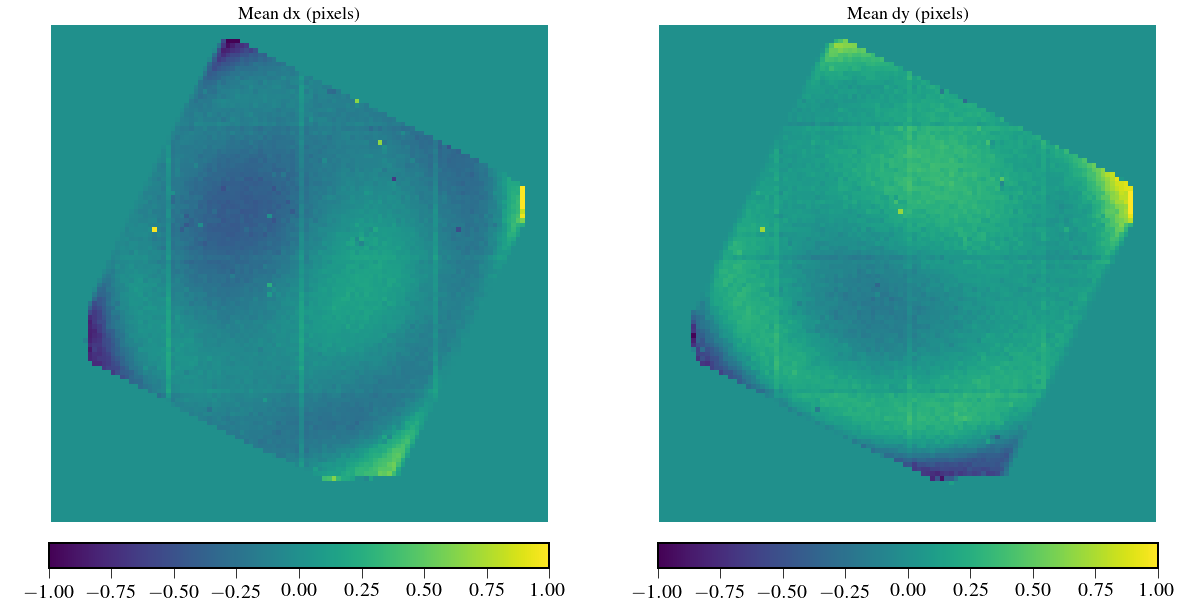

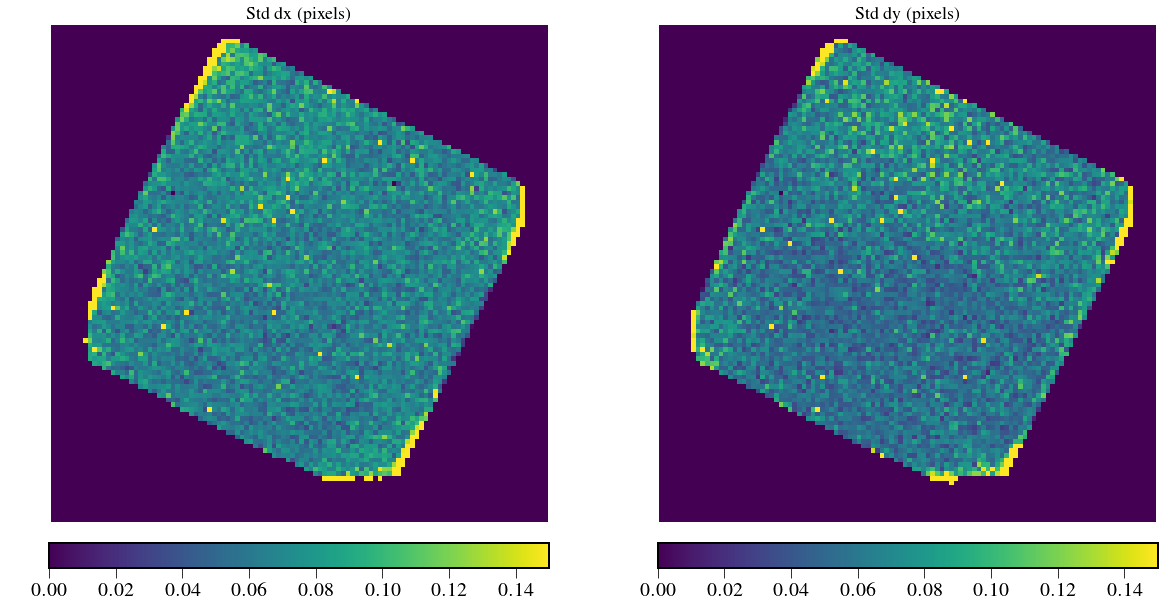

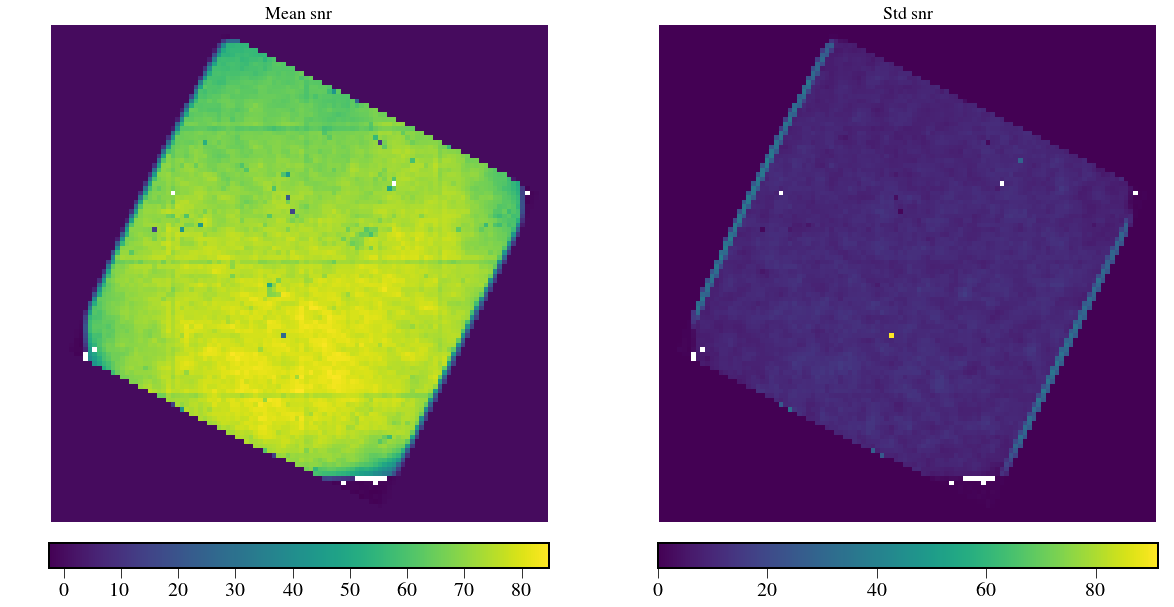

In [21]:
dx = fits.getdata('/Users/mrizzo/IFS/crispy/crispy/ReferenceFiles/Calibra_170425/dxlistarr.fits')
dy = fits.getdata('/Users/mrizzo/IFS/crispy/crispy/ReferenceFiles/Calibra_170425/dylistarr.fits')
snr = fits.getdata('/Users/mrizzo/IFS/crispy/crispy/ReferenceFiles/Calibra_170425/snrlistarr.fits')
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(np.mean(dx,axis=0).T,vmin=-1.0,vmax=1.0)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Mean dx (pixels)')

plt.axis('off')
plt.subplot(122)
plt.imshow(np.mean(dy,axis=0).T,vmin=-1.0,vmax=1.0)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Mean dy (pixels)')

plt.axis('off')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(np.std(dx,axis=0).T,vmax=0.15)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Std dx (pixels)')

plt.axis('off')
plt.subplot(122)
plt.imshow(np.std(dy,axis=0).T,vmax=0.15)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Std dy (pixels)')
plt.axis('off')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(np.mean(snr,axis=0).T)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Mean snr')
plt.axis('off')
plt.subplot(122)
plt.imshow(np.std(snr,axis=0).T)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Std snr')
plt.axis('off')


# Extract a monochromatic wavelength

One other possibility to verify the wavelength calibration (and potentially correct for it) is to extract a monochromatic flatfield at a known wavelength and check that all the flux is at the correct slice/wavelength.

(-0.5, 107.5, -0.5, 107.5)

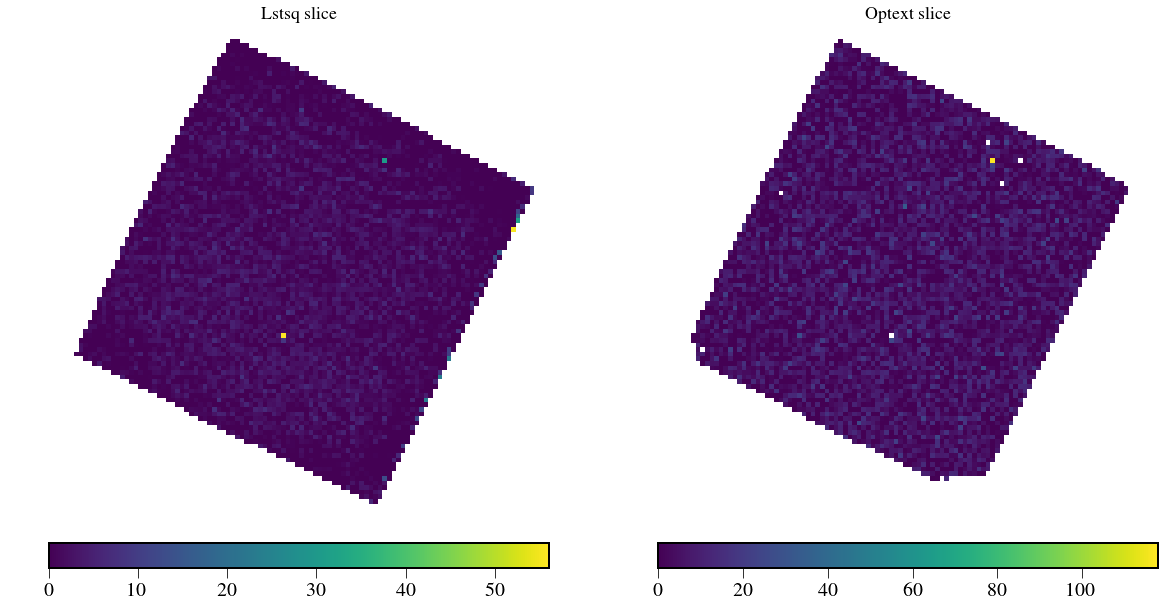

In [10]:
lstsq = fits.getdata('/Users/mrizzo/IFS/crispy/crispy/SimResults/det665_red_lstsq.fits')
optext = fits.getdata('/Users/mrizzo/IFS/crispy/crispy/SimResults/det665_red_optext.fits')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(lstsq[6],vmin=0)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Lstsq slice')
plt.axis('off')
plt.subplot(122)
plt.imshow(optext[6],vmin=0)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Optext slice')
plt.axis('off')


## Load the PISCES parameters to construct wavelength axis

In [11]:
import os
os.chdir('/Users/mrizzo/IFS/crispy/crispy/PISCES/')
from params import Params
par = Params()
from crispy.tools.reduction import calculateWaveList
lam_midpts,_ = calculateWaveList(par)

crispy - INFO - Reduced cube will have 25 wavelength bins


## Plot3D through the center of the cube

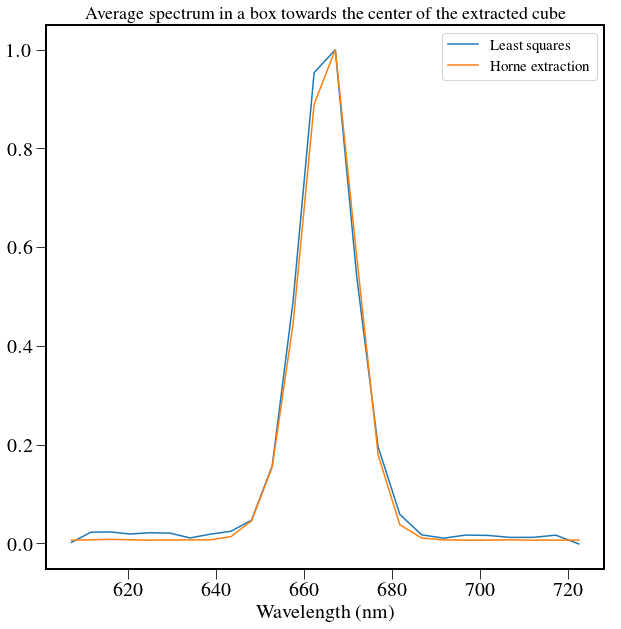

In [12]:
crop=40
plt.figure(figsize=(10,10))
sumbox_lstsq = np.nansum(np.nansum(lstsq[:,crop:-crop,crop:-crop],axis=1),axis=1)
sumbox_optext = np.nansum(np.nansum(optext[:,crop:-crop,crop:-crop],axis=1),axis=1)
plt.plot(lam_midpts,sumbox_lstsq/np.amax(sumbox_lstsq),label='Least squares')
plt.plot(lam_midpts,sumbox_optext/np.amax(sumbox_optext),label='Horne extraction')
plt.xlabel('Wavelength (nm)')
plt.title('Average spectrum in a box towards the center of the extracted cube')
plt.legend()

## Take wavelength "centroid" through the cube

This method consists of taking a centroid in the wavelength axis of the extracted cube. This centroid should correspond to the wavelength of the input monochromatic flatfield, in this case 665nm.

In [13]:
centroids_lstsq = np.nansum(lam_midpts[:,np.newaxis,np.newaxis]*lstsq,axis=0)/np.nansum(lstsq,axis=0)
centroids_optext = np.nansum(lam_midpts[:,np.newaxis,np.newaxis]*optext,axis=0)/np.nansum(optext,axis=0)

# use a sigma-clipped statistic routine to avoid outliers and bad lenslets
from astropy.stats import sigma_clipped_stats
mean_lstsq, median_lstsq, std_lstsq = sigma_clipped_stats(centroids_lstsq, sigma=3.0, iters=5)
print mean_lstsq, median_lstsq, std_lstsq
mean_optext, median_optext, std_optext = sigma_clipped_stats(centroids_optext, sigma=3.0, iters=5)
print mean_optext, median_optext, std_optext

664.795901541 664.769399541 0.826183020074
665.081419758 665.089743337 0.610421257752


## Plot wavelength "centroid" for all psflets

(-0.5, 107.5, -0.5, 107.5)

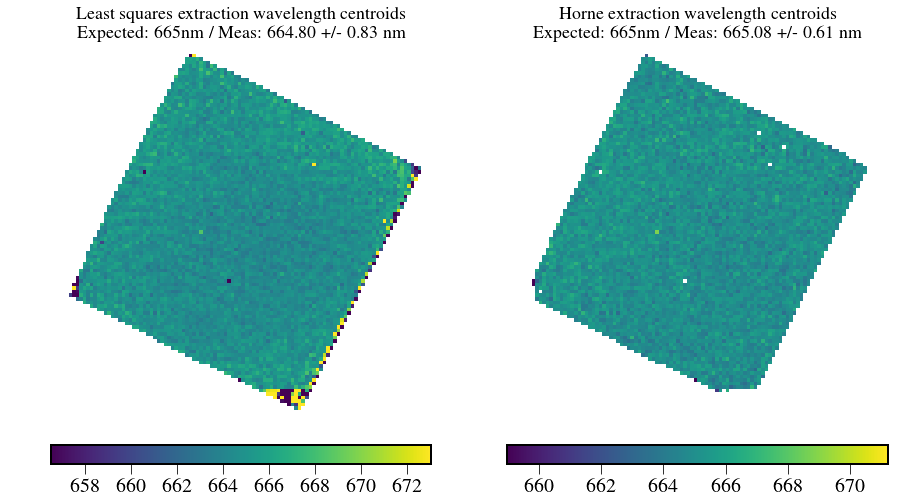

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(centroids_lstsq,vmin=median_lstsq-10*std_lstsq,vmax=median_lstsq+10*std_lstsq)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Least squares extraction wavelength centroids \nExpected: 665nm / Meas: {:.2f} +/- {:.2f} nm'.format(mean_lstsq,std_lstsq))
plt.axis('off')
plt.subplot(122)
plt.imshow(centroids_optext,vmin=median_optext-10*std_optext,vmax=median_optext+10*std_optext)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Horne extraction wavelength centroids \nExpected: 665nm / Meas: {:.2f} +/- {:.2f} nm'.format(mean_optext,std_optext))
plt.axis('off')



Authors: Maxime J. Rizzo and GSFC IFS team